## Github URL

---

https://github.com/Arravee/CNN_Cancer

## Get the Data

We will be using the terminal commands below to downlaod the data directly. Please not that to use the Kaggle API with this method, we must first downlaod our kaggle.json file which can be found under the API section of our Kaggle profile. I will also be clearing the output of the unzip command in the final report as it takes too much space.

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle competitions download histopathologic-cancer-detection


100% 6.30G/6.31G [00:49<00:00, 178MB/s]
100% 6.31G/6.31G [00:49<00:00, 137MB/s]


In [ ]:
! unzip histopathologic-cancer-detection.zip

## Problem and Dataset Description

One field that could greatly benefit from the advancements in Machine Learning is the medical field and to that end research regarding the applications of machine learning techniques have going on for a decade. In this project, we will look at small patches (32 X 32) to identify metastatic cancer. This is ultimately a binary classification problem for which we will utilize a Convolution Neural Network (CNN). A positive label indicates that there is at least one pixel of tumor tissue identified. Kaggle has already gotten rid of duplicates from the original PCam dataset. According to Kaggle the combined dataset has over 270,000 samples and can be found here: 
https://www.kaggle.com/competitions/histopathologic-cancer-detection/data?select=train

In [11]:
import numpy as np
import pandas as pd
import sys
import os
import multiprocessing
from datetime import datetime

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers import PReLU
from keras.initializers import Constant

from keras.models import Sequential, Model,load_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split


## EDA

In [13]:
#Import the Dataset and get a general initial look at it
train_df = pd.read_csv('train_labels.csv', dtype=str)
print(train_df.shape)
train_df.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [14]:
#Now let's look at value counts. This is important because we have worked with heavily skewed data berfore and
#if there a low amount of positive/negative samples we will need to adjust the ratio before plugging the data into 
#our future models.

train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

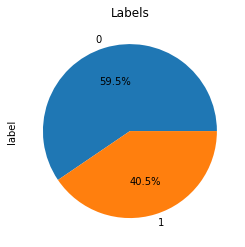

In [15]:
train_df['label'].value_counts().plot(kind='pie',grid=True,title='Labels', autopct='%1.1f%%')

The proportion of positive to negative cases is perfectly fine so we can now move forward to looking at the corresponding images. To do this we will be utilizing mpimg and plt as part of the matplotlib library.

Shape of image: (96, 96, 3)


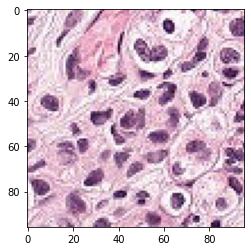

In [16]:
sample_img = mpimg.imread(f'train/{train_df.iloc[100,0]}.tif')
imgplot = plt.imshow(sample_img)

print('Shape of image:', sample_img.shape)

From here we will plot an array of images with the labels. This will give us a general idea for the image data and while to the untrained eye the images may not be particularly discernable, this step is very important to use as an initial glance over for any medical professionals utilizing this model for their research.   

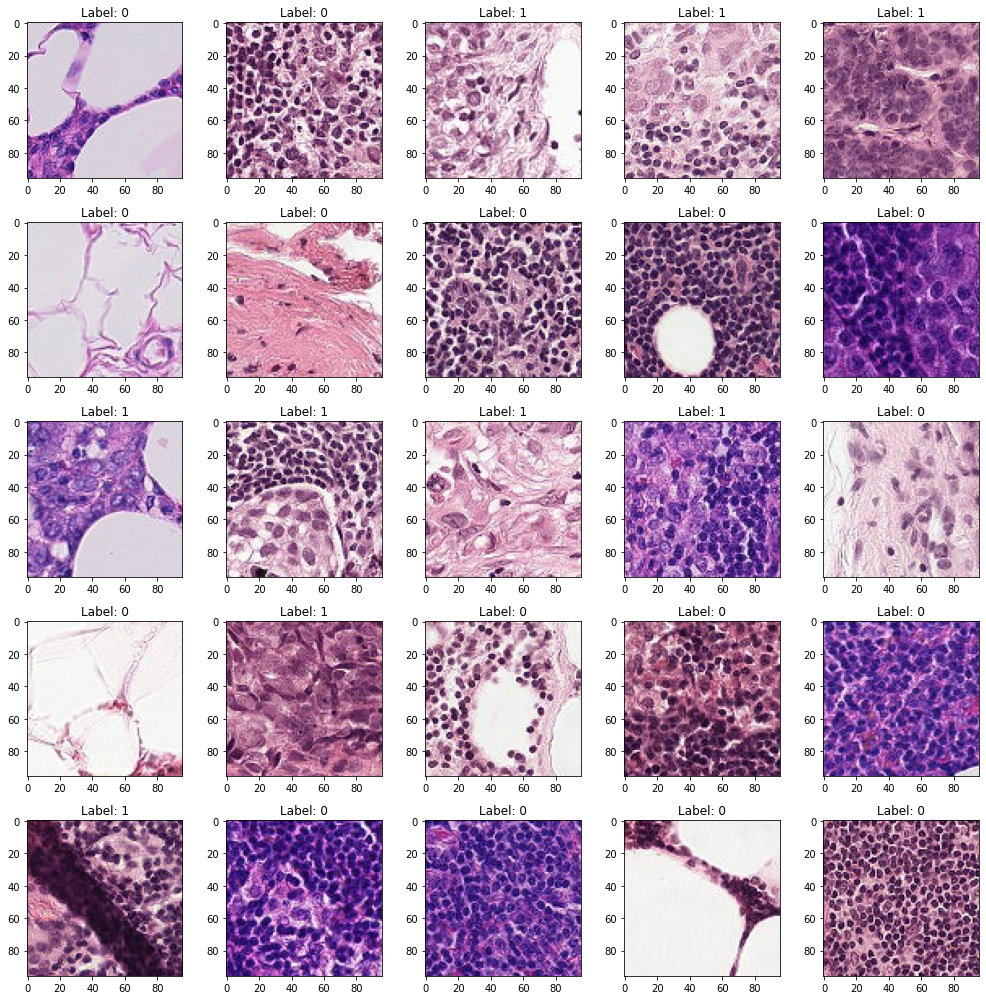

In [17]:
num_sample_imgs = 25

random_index = np.random.choice(train_df.index,num_sample_imgs)
fig, ax = plt.subplots(5, 5,figsize=(14,14))

for i in range(num_sample_imgs):
    ax = plt.subplot(5, 5, i+1)
    img = mpimg.imread(f'train/{train_df.iloc[random_index[i],0]}.tif')
    ax.imshow(img)
    label = train_df.iloc[random_index[i],1]
    ax.set_title('Label: %s'%label)
    
plt.tight_layout()

## Dmodel Architecture
We will now move on to creating our model architecture. First, we will split the data into a training and validation dataset with a 7:3 ratio. From there we want to add ".tif" to the end of all the ids so we can call the relevant images.

In [18]:
split_train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=42)

print(7/3)
print(len(split_train_df)/len(val_df))

split_train_df.head()


2.3333333333333335
2.333308083868622


,id,label
10025,e087c93930b86f8f40e7a9b3837276f58f02ce7e,1
118508,40f8af5d6c9691bf0a30b271d569f66aebb75ea0,0
151515,b0a5e576b3e969014a96c0b0151c2a402b6fe156,0
3069,43a18b68a06866d5738a9e9da69e22ed6718c285,0
73661,780af7cc151533b965295a43b02c7bbd6b3402d3,1


In [19]:
split_train_df['id'] = split_train_df['id']+'.tif'
val_df['id'] = val_df['id']+'.tif'

split_train_df.head()

,id,label
10025,e087c93930b86f8f40e7a9b3837276f58f02ce7e.tif,1
118508,40f8af5d6c9691bf0a30b271d569f66aebb75ea0.tif,0
151515,b0a5e576b3e969014a96c0b0151c2a402b6fe156.tif,0
3069,43a18b68a06866d5738a9e9da69e22ed6718c285.tif,0
73661,780af7cc151533b965295a43b02c7bbd6b3402d3.tif,1


Next, we want to load the corresponding images. However, loading them as is will place a heavy load on this notebook. Therefore we will use Keras' ImageDataGenerator method to rescale the images. ImageDataGenerator is a form of image augmentation, a set of techniques that can efficiently different transformations to an image. More information on them can be found here: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/.

As I was looking at past work I found most people settled on a 1/255 scale for the best results. One such notebook, which I will be using as my main reference when building out this project can be found here: https://www.kaggle.com/code/luizmartinez/histopathologic-cancer-detection-image-classific


In [20]:
train_datagen=ImageDataGenerator(rescale=1/255)

In [21]:
train_generator=train_datagen.flow_from_dataframe(dataframe=split_train_df,
                directory="train/",
                x_col="id",y_col="label",batch_size=32,seed=42,shuffle=True,
                class_mode="binary",target_size=(96,96))

valid_generator=train_datagen.flow_from_dataframe(dataframe=val_df, 
                directory="train/",
                x_col="id",y_col="label",batch_size=32,seed=42,shuffle=True,
                class_mode="binary",target_size=(96,96))

Found 154017 validated image filenames belonging to 2 classes.
Found 66008 validated image filenames belonging to 2 classes.


Now we can start experimenting with different models and their corresponding hyperparameters. We will start with a VGG model with 3 and 4 layers respectively using relu activation functions. Afterward, will we flatten the image and use a final activation with the softmax function.  

In [ ]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (96,96,3)))
model_1.add(Conv2D(32, (3,3), activation = 'relu'))
model_1.add(Conv2D(32, (3,3), activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = (2,2))) 
model_1.add(BatchNormalization())

model_1.add(Conv2D(64, (3,3), activation = 'relu'))
model_1.add(Conv2D(64, (3,3), activation = 'relu'))
model_1.add(Conv2D(64, (3,3), activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = (2,2))) 
model_1.add(BatchNormalization())

model_1.add(Conv2D(128, (3,3), activation = 'relu'))
model_1.add(Conv2D(128, (3,3), activation = 'relu'))
model_1.add(Conv2D(128, (3,3), activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = (2,2)))
model_1.add(BatchNormalization())

model_1.add(Flatten())
model_1.add(Dense(256, activation = "relu"))
model_1.add(Dropout(0.25))
model_1.add(Dense(1, activation = 'relu'))

model_1.add(Dense(128, activation = "relu"))
model_1.add(Dropout(0.25))
model_1.add(Dense(1, activation = 'relu'))

model_1.add(Dropout(0.25))
model_1.add(Dense(1, activation='softmax'))
opt = tf.keras.optimizers.Adam(0.001)
model_1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 45, 45, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        1

In [22]:
train_step=(train_generator.n//train_generator.batch_size)
val_step=(valid_generator.n//valid_generator.batch_size)

In [ ]:



VGG_1 = model_1.fit_generator(generator=train_generator,
                    steps_per_epoch=train_step,
                    validation_data=valid_generator,
                    validation_steps=val_step,
                    epochs=12, verbose=1
)





Epoch 1/12
4813/4813 [==============================] - 144s 27ms/step - loss: 0.5475 - accuracy: 0.4052 - val_loss: 0.5047 - val_accuracy: 0.4047
Epoch 2/12
4813/4813 [==============================] - 129s 27ms/step - loss: 0.4924 - accuracy: 0.4052 - val_loss: 0.3965 - val_accuracy: 0.4047
Epoch 3/12
4813/4813 [==============================] - 127s 26ms/step - loss: 0.4690 - accuracy: 0.4052 - val_loss: 0.3627 - val_accuracy: 0.4047
Epoch 4/12
4813/4813 [==============================] - 127s 26ms/step - loss: 0.4507 - accuracy: 0.4052 - val_loss: 0.3690 - val_accuracy: 0.4047
Epoch 5/12
4813/4813 [==============================] - 127s 26ms/step - loss: 0.4367 - accuracy: 0.4052 - val_loss: 0.7070 - val_accuracy: 0.4047
Epoch 6/12
4813/4813 [==============================] - 127s 26ms/step - loss: 0.4230 - accuracy: 0.4052 - val_loss: 0.3655 - val_accuracy: 0.4048
Epoch 7/12
4813/4813 [==============================] - 127s 26ms/step - loss: 0.4170 - accuracy: 0.4051 - val_loss: 0

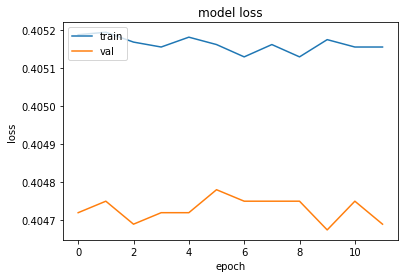

In [ ]:
plt.plot(VGG_1.history['accuracy'])
plt.plot(VGG_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (96,96,3)))
model_2.add(Conv2D(32, (3,3), activation = 'relu'))
model_2.add(Conv2D(32, (3,3), activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2,2))) 
model_2.add(BatchNormalization())

model_2.add(Conv2D(64, (3,3), activation = 'relu'))
model_2.add(Conv2D(64, (3,3), activation = 'relu'))
model_2.add(Conv2D(64, (3,3), activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2,2))) 
model_2.add(BatchNormalization())

model_2.add(Conv2D(128, (3,3), activation = 'relu'))
model_2.add(Conv2D(128, (3,3), activation = 'relu'))
model_2.add(Conv2D(128, (3,3), activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2,2))) 
model_2.add(BatchNormalization())

model_2.add(Conv2D(256, (3,3), activation = 'relu'))
model_2.add(Conv2D(256, (3,3), activation = 'relu'))
#model_2.add(Conv2D(256, (3,3), activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2,2))) 
model_2.add(BatchNormalization())

model_2.add(Flatten())
model_2.add(Dense(512, activation = "relu"))
model_2.add(Dropout(0.25))
model_2.add(Dense(1, activation = 'relu'))

model_2.add(Dense(256, activation = "relu"))
model_2.add(Dropout(0.25))
model_2.add(Dense(1, activation = 'relu'))

model_2.add(Dense(64, activation = "relu"))
model_2.add(Dropout(0.25))
model_2.add(Dense(1, activation = 'relu'))


model_2.add(Dropout(0.25))
model_2.add(Dense(1, activation='softmax'))
opt = tf.keras.optimizers.Adam(0.001)
model_2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 conv2d_26 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 45, 45, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_27 (Conv2D)          (None, 43, 43, 64)       

In [ ]:
VGG_2 = model_2.fit_generator(generator=train_generator,
                    steps_per_epoch=train_step,
                    validation_data=valid_generator,
                    validation_steps=val_step,
                    epochs=15, verbose=1
)


Epoch 1/15
4813/4813 [==============================] - 135s 28ms/step - loss: 0.6449 - accuracy: 0.4052 - val_loss: nan - val_accuracy: 0.5953
Epoch 2/15
4813/4813 [==============================] - 133s 28ms/step - loss: 0.5680 - accuracy: 0.4051 - val_loss: nan - val_accuracy: 0.5953
Epoch 3/15
4813/4813 [==============================] - 133s 28ms/step - loss: 0.5390 - accuracy: 0.4052 - val_loss: nan - val_accuracy: 0.5953
Epoch 4/15
4813/4813 [==============================] - 133s 28ms/step - loss: 0.5232 - accuracy: 0.4052 - val_loss: nan - val_accuracy: 0.5953
Epoch 5/15
4813/4813 [==============================] - 134s 28ms/step - loss: 0.5149 - accuracy: 0.4052 - val_loss: nan - val_accuracy: 0.5953
Epoch 6/15
4813/4813 [==============================] - 134s 28ms/step - loss: 0.5048 - accuracy: 0.4052 - val_loss: nan - val_accuracy: 0.5952
Epoch 7/15
4813/4813 [==============================] - 149s 31ms/step - loss: 0.4993 - accuracy: 0.4052 - val_loss: nan - val_accuracy:

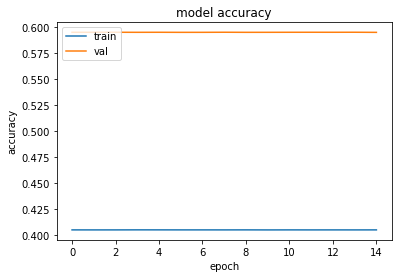

In [ ]:
plt.plot(VGG_2.history['accuracy'])
plt.plot(VGG_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_3 = Sequential()
model_3.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (96,96,3)))
model_3.add(Conv2D(32, (3,3), activation = 'relu'))
model_3.add(Conv2D(32, (3,3), activation = 'relu'))
model_3.add(Conv2D(32, (3,3), activation = 'relu'))
model_3.add(Conv2D(32, (3,3), activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2,2))) 
model_3.add(BatchNormalization())

model_3.add(Conv2D(64, (3,3), activation = 'relu'))
model_3.add(Conv2D(64, (3,3), activation = 'relu'))
model_3.add(Conv2D(64, (3,3), activation = 'relu'))
model_3.add(Conv2D(64, (3,3), activation = 'relu'))
model_3.add(Conv2D(64, (3,3), activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2,2))) 
model_3.add(BatchNormalization())

model_3.add(Conv2D(128, (3,3), activation = 'relu'))
model_3.add(Conv2D(128, (3,3), activation = 'relu'))
model_3.add(Conv2D(128, (3,3), activation = 'relu'))
model_3.add(Conv2D(128, (3,3), activation = 'relu'))
model_3.add(Conv2D(128, (3,3), activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2,2))) 
model_3.add(BatchNormalization())

model_3.add(Flatten())
model_3.add(Dense(256, activation = "relu"))
model_3.add(Dropout(0.25))
model_3.add(Dense(1, activation = 'relu'))

model_3.add(Dense(128, activation = "relu"))
model_3.add(Dropout(0.25))
model_3.add(Dense(1, activation = 'relu'))

model_3.add(Dense(64, activation = "relu"))
model_3.add(Dropout(0.25))
model_3.add(Dense(1, activation = 'relu'))


model_3.add(Dropout(0.25))
model_3.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model_3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 conv2d_36 (Conv2D)          (None, 94, 94, 32)        9248      
                                                                 
 conv2d_37 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 conv2d_38 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 conv2d_39 (Conv2D)          (None, 88, 88, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 44, 44, 32)       0         
 g2D)                                                            
                                                      

In [ ]:
VGG_3 = model_3.fit_generator(generator=train_generator,
                    steps_per_epoch=train_step,
                    validation_data=valid_generator,
                    validation_steps=val_step,
                    epochs=15, verbose=1
)

Epoch 1/15
4813/4813 [==============================] - 174s 36ms/step - loss: 0.6171 - accuracy: 0.6272 - val_loss: 0.7256 - val_accuracy: 0.4047
Epoch 2/15
4813/4813 [==============================] - 172s 36ms/step - loss: 0.5631 - accuracy: 0.6934 - val_loss: 0.5182 - val_accuracy: 0.8085
Epoch 3/15
4813/4813 [==============================] - 172s 36ms/step - loss: 0.5475 - accuracy: 0.7072 - val_loss: 0.9680 - val_accuracy: 0.7448
Epoch 4/15
4813/4813 [==============================] - 172s 36ms/step - loss: 0.5389 - accuracy: 0.7128 - val_loss: 0.7590 - val_accuracy: 0.4048
Epoch 5/15
4813/4813 [==============================] - 173s 36ms/step - loss: 0.5342 - accuracy: 0.7169 - val_loss: 0.5631 - val_accuracy: 0.7760
Epoch 6/15
4813/4813 [==============================] - 172s 36ms/step - loss: 0.5295 - accuracy: 0.7222 - val_loss: 1.9913 - val_accuracy: 0.6181
Epoch 7/15
4813/4813 [==============================] - 172s 36ms/step - loss: 0.5329 - accuracy: 0.7198 - val_loss: 0

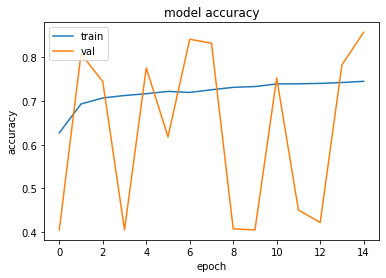

In [ ]:
plt.plot(VGG_3.history['accuracy'])
plt.plot(VGG_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
model_4 = Sequential()

model_4.add(Conv2D(32, (3,3), padding = 'same', input_shape = (96,96,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(Conv2D(32, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(Conv2D(32, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(Conv2D(32, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(Conv2D(32, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(MaxPooling2D(pool_size = (2,2))) 
model_4.add(BatchNormalization())

model_4.add(Conv2D(64, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(Conv2D(64, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(Conv2D(64, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(Conv2D(64, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(Conv2D(64, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(MaxPooling2D(pool_size = (2,2))) 
model_4.add(BatchNormalization())

model_4.add(Conv2D(128, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(Conv2D(128, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(Conv2D(128, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(Conv2D(128, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(Conv2D(128, (3,3)))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model_4.add(MaxPooling2D(pool_size = (2,2))) 
model_4.add(BatchNormalization())

model_4.add(Flatten())
model_4.add(Dense(512, activation = "relu"))
model_4.add(Dropout(0.25))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))

model_4.add(Flatten())
model_4.add(Dense(256, activation = "relu"))
model_4.add(Dropout(0.25))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))

model_4.add(Dense(64, activation = "relu"))
model_4.add(Dropout(0.25))
model_4.add(PReLU(alpha_initializer=Constant(value=0.25)))


model_4.add(Dropout(0.25))
model_4.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model_4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 p_re_lu (PReLU)             (None, 96, 96, 32)        294912    
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        9248      
                                                                 
 p_re_lu_1 (PReLU)           (None, 94, 94, 32)        282752    
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 p_re_lu_2 (PReLU)           (None, 92, 92, 32)        270848    
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9

In [24]:
VGG_4 = model_4.fit_generator(generator=train_generator,
                    steps_per_epoch=train_step,
                    validation_data=valid_generator,
                    validation_steps=val_step,
                    epochs=15, verbose=1
)

Epoch 1/15
4813/4813 [==============================] - 285s 56ms/step - loss: 0.4502 - accuracy: 0.8073 - val_loss: 0.4137 - val_accuracy: 0.8371
Epoch 2/15
4813/4813 [==============================] - 268s 56ms/step - loss: 0.3818 - accuracy: 0.8413 - val_loss: 0.3319 - val_accuracy: 0.8610
Epoch 3/15
4813/4813 [==============================] - 268s 56ms/step - loss: 0.3287 - accuracy: 0.8663 - val_loss: 0.3373 - val_accuracy: 0.8647
Epoch 4/15
4813/4813 [==============================] - 267s 55ms/step - loss: 0.2865 - accuracy: 0.8875 - val_loss: 0.3004 - val_accuracy: 0.8760
Epoch 5/15
4813/4813 [==============================] - 267s 56ms/step - loss: 0.2500 - accuracy: 0.9045 - val_loss: 0.2986 - val_accuracy: 0.8808
Epoch 6/15
4813/4813 [==============================] - 267s 55ms/step - loss: 0.2164 - accuracy: 0.9190 - val_loss: 0.2982 - val_accuracy: 0.8782
Epoch 7/15
4813/4813 [==============================] - 267s 55ms/step - loss: 0.1843 - accuracy: 0.9331 - val_loss: 0

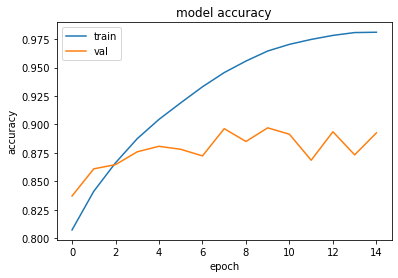

In [25]:
plt.plot(VGG_4.history['accuracy'])
plt.plot(VGG_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Results and Analysis
 
Our first model architecture was a 3 X 3 with the final activation layer being a softmax function due to its probabilistic properties. We never expected this to be the final model but instead a base to compare future architectures. This model was consistent throughout the epochs but had a very low training and validation accuracy, hovering around 40% for both. 

In our next model, we added a new layer at Conv2d(256). We observed our validation accuracy increase by 20% but the graph showed a very troubling pattern. the values were the same throughout the epochs. Our model was not "learning". 

This meant we had to take make some drastic measures. We went back to 3 layers but instead of 3x3, we used a 3x5 architecture. We also added a padding feature and after further research changed the final activation function from softmax to sigmoid. This generated the results we were looking for and a graph that was more in line with what we expected. Our loss was slightly higher but our training accuracy seemed to converge at 70% and our validation accuracy peaked at 85%. This assured us that this was the way forward. 

So for the final attempt, we looked at another major factor that remained constant throughout. The activation functions in the layers. Throughout the first three models, we were using "relu". We wanted to use PReLU. The advantage of PReLU is it doesn't use a predetermined slope and instead makes the coefficient of leakage into a parameter that the NN learns. This turned out to be a success. Our training accuracy ended at 98% and our validation accuracy was slowly climbing to 90%. We also observed the smallest loss by far at the 15th epoch.


In [28]:
test_set = os.listdir('test/')

In [29]:
test_df = pd.DataFrame(test_set)
test_df.columns = ['id']
test_df.head()

,id
0,039003bc42701337bf5e9bb1298779cd2b85ec8c.tif
1,460a81a36562d5fd985ea84f2b03b88b0d48f5ae.tif
2,81d0aa3c20f021c2fc12a79c359ea29fa499425f.tif
3,117952f4d77f017145e0d3fcad697b020c3cccf7.tif
4,7076ce31d5c7b00e4a329436629e4d713803286e.tif


In [30]:
test_datagen=ImageDataGenerator(rescale=1/255)

test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,directory="test/",
                x_col="id",batch_size=64,seed=1234,shuffle=False,
                class_mode=None,target_size=(96,96))

Found 57458 validated image filenames.


In [32]:
STEP_SIZE_TEST=test_generator.n/2

preds = model_4.predict_generator(generator=test_generator,steps=STEP_SIZE_TEST, verbose = 1)

  898/28729 [..............................] - ETA: 16:01

28729/28729 [==============================] - 32s 1ms/step


In [33]:
predictions = []

for pred in preds:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
        
predictions[:10]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [34]:
submission = test_df.copy()
submission['id']=submission['id'].str[:-4]
submission['label']=predictions
submission.head()


,id,label
0,039003bc42701337bf5e9bb1298779cd2b85ec8c,1
1,460a81a36562d5fd985ea84f2b03b88b0d48f5ae,0
2,81d0aa3c20f021c2fc12a79c359ea29fa499425f,0
3,117952f4d77f017145e0d3fcad697b020c3cccf7,0
4,7076ce31d5c7b00e4a329436629e4d713803286e,0


In [36]:
len(submission)

57458

In [35]:
submission.to_csv('cancer_cnn_submission.csv',index=False)

## Conclusion 
There are a few areas of improvement. The most obvious is adding more layers to the model. However, the more layers we add the longer the runtime to initialize the said model. We will encounter the same performance issues if we increase the number of epochs, perhaps to 20 or 25. This performance hit isn't terrible as we ran this using Google Colab Pro but if you were to run this without a GPU each epoch could take 20-50 minutes. 

Another area is the Keras optimizer. All of our models used Adam however it would be prudent to test alternatives if we were to expand on this object, the same goes for other activation methods. 

Finally, we could try other types of CNN such as ResNet, which other people have had some success with. 

Overall, our best model performance on the test set was in line with what we expected and therefore the best model will serve as a good jumping off point to continue research in this field using CNN. 
